# Мегалайн

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель**

    В вашем распоряжении данные о поведении клиентов, которые уже
    перешли на эти тарифы (из проекта курса «Статистический анализ
    данных»). Нужно построить модель для задачи классификации, 
    которая выберет подходящий тариф. Предобработка данных не 
    понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75.


## 1. Открывавем и и изучаем файл.

Импортируем библиотеки.

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import dump
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

Убираем длинные циферки.

In [71]:
pd.set_option('display.float_format', '{:,.3f}'.format)

Отключаем лишние предупреждения.

In [72]:
import warnings
warnings.filterwarnings('ignore')

Читаем файл с данными и сохраняем в df.

In [73]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    ! gdown --id 1yWWxa1jk9vdaK2eKWm2U602wu1bz7S8u
    df = pd.read_csv('/content/users_behavior.csv')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1yWWxa1jk9vdaK2eKWm2U602wu1bz7S8u
To: /content/users_behavior.csv
100% 134k/134k [00:00<00:00, 62.3MB/s]


### Таблица данных

Смотрим табличку.

In [74]:
display(df.columns)
print()
display(df)

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

,calls,minutes,messages,mb_used,is_ultra
0,40.000,311.900,83.000,"19,915.420",0
1,85.000,516.750,56.000,"22,696.960",0
2,77.000,467.660,86.000,"21,060.450",0
3,106.000,745.530,81.000,"8,437.390",1
4,66.000,418.740,1.000,"14,502.750",0
...,...,...,...,...,...
3209,122.000,910.980,20.000,"35,124.900",1
3210,25.000,190.360,0.000,"3,275.610",0
3211,97.000,634.440,70.000,"13,974.060",0
3212,64.000,462.320,90.000,"31,239.780",0


### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

    • сalls — количество звонков,
    • minutes — суммарная длительность звонков в минутах,
    • messages — количество sms-сообщений,
    • mb_used — израсходованный интернет-трафик в Мб,
    • is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).


### Инфо. Пропуски. Описание.

Посмотрим заполненость таблицы.

In [75]:
# 
print('\nИнфо:')
print(df.info())                                # сколько значений и в каком формате
print('\nПропусков:')
print(df.isna().mean())                         # подсчёт пропусков в долях
print('\nОписание:')
display(df.describe())                          # вдруг чего "на глазок" проявится 
print('\nДубликатов =', df.duplicated().sum())  # проверим дубликаты


Инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None

Пропусков:
calls      0.000
minutes    0.000
messages   0.000
mb_used    0.000
is_ultra   0.000
dtype: float64

Описание:


,calls,minutes,messages,mb_used,is_ultra
count,"3,214.000","3,214.000","3,214.000","3,214.000","3,214.000"
mean,63.039,438.209,38.281,"17,207.674",0.306
std,33.236,234.570,36.148,"7,570.968",0.461
min,0.000,0.000,0.000,0.000,0.000
25%,40.000,274.575,9.000,"12,491.903",0.000
50%,62.000,430.600,30.000,"16,943.235",0.000
75%,82.000,571.927,57.000,"21,424.700",1.000
max,244.000,"1,632.060",224.000,"49,745.730",1.000



Дубликатов = 0


##### Вывод

- Количество записей 3214.
- Пропусков данных нет.
- Дубликатов не имеется.

## 2. Обучающая, валидационная и тестовая выборки.

Делим табличку на тренировочную (60%), валидационную (20%) и тестовую (20%).

In [76]:
features = df.drop(['is_ultra'], axis=1)

Будем прогнозировать тариф.

In [77]:
target = df['is_ultra']

Отделяем 20% данных для тестовой выборки.

In [78]:
features_train, features_test, target_train, target_test = train_test_split(
                                                                features, target, 
                                                                test_size=0.20, 
                                                                random_state=1980)

Отделяем 20% данных для валидационной выборки.

In [79]:
features_train, features_valid, target_train, target_valid = train_test_split(
                                                                features_train, target_train, 
                                                                test_size=0.25, 
                                                                random_state=1980)

## 3. Качество разных моделей.

### DecisionTreeClassifier

In [80]:
best_model_dt_c = None
best_result_dt_c = 0

Значимым количеством ответов считаем не менее 1% от общего количества ответов.

In [81]:
msl = np.ceil(len(df['is_ultra']) / 100)
print("msl =", msl)
for depth in range(1, 100):                   # определяем лучшую глубину дерева
    model_dt_c = DecisionTreeClassifier(random_state=1980, 
                                        max_depth=depth, 
                                        min_samples_leaf=33)
    model_dt_c.fit(features_train, 
                   target_train)
    predictions = model_dt_c.predict(features_valid)
    result = accuracy_score(target_valid, 
                            predictions)      # считаем качество модели
    if result > best_result_dt_c:
        best_depth_dt_c_val = depth
        best_model_dt_c_val = model_dt_c
        best_result_dt_c = result
result_dt_c_val = best_result_dt_c
print("\nТочность лучшей модели `Решающее дерево`:", result_dt_c_val)
print("Лучшая модель:", best_model_dt_c_val)

msl = 33.0

Точность лучшей модели `Решающее дерево`: 0.8040435458786936
Лучшая модель: DecisionTreeClassifier(max_depth=6, min_samples_leaf=33, random_state=1980)


### RandomForestClassifier

In [69]:
best_model_rf_c = None
best_result_rf_c = 0
for est in range(1, 100):                 # количество деревьев 100
    model_rf_c = RandomForestClassifier(random_state=1980, 
                                        n_estimators=est)
    model_rf_c.fit(features_train, 
                   target_train)
    # считаем качество модели на валидационной выборке
    result = model_rf_c.score(features_valid,
                              target_valid)
    if result > best_result_rf_c:
        best_est_rf_c_val = est
        best_model_rf_c_val = model_rf_c  # сохраняем наилучшую модель
        best_result_rf_c = result         # сохраняем наилучшее accuracy на валидационных данных
result_rf_c_val = best_result_rf_c
print()
print("Точность наилучшей модели `Случайный лес`:", result_rf_c_val)
print("Лучшая модель:", best_model_rf_c_val)


Точность наилучшей модели `Случайный лес`: 0.8227060653188181
Лучшая модель: RandomForestClassifier(n_estimators=30, random_state=1980)


### LogisticRegression

In [82]:
best_model_log_r = None
best_result_log_r = 0
max_iter = 3
for iter in range(1, 100):                    # проверял до 500
    model_log_r = LogisticRegression(random_state=1980, 
                                     solver='lbfgs', 
                                     max_iter=iter)
    model_log_r.fit(features_train, 
                    target_train)
    # считаем значение метрики accuracy на валидационной выборке
    result = model_log_r.score(features_valid, 
                               target_valid)
    if result > best_result_log_r:
        best_model_log_r = model_log_r
        best_result_log_r = result
        best_iter_log_r_val = iter
result_log_r_val = best_result_log_r
print()
print("Точность логистической регрессии:", result_log_r_val)
print("Лучшее количество итераций логистической регрессии:", best_iter_log_r_val)


Точность логистической регрессии: 0.76049766718507
Лучшее количество итераций логистической регрессии: 68


##### Вывод

    Модели можно отранжировать по точности предсказания:

        1.   Случайный лес
        2.   Решающее дерево
        3.   Логистическая регрессия



Убеждаемся, что модели регрессии можно не рассматривать.

Считаем RMSE:

In [83]:
predictions = pd.Series(target.mean(), 
                        index=target.index)
mse = mean_squared_error(target, 
                         predictions)
rmse = mse** (0.5)
print()
print("RMSE:", rmse)


RMSE: 0.46102797293043907


Дерево решений в регрессии.

In [84]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 10):
    model_dt_r = DecisionTreeRegressor(random_state=1980, 
                                       max_depth=depth)
    model_dt_r.fit(features_train, 
                   target_train)
    predictions_valid = model_dt_r.predict(features_valid)
    # считаем значение метрики rmse на валидационной выборке
    result = (mean_squared_error(target_valid, 
                                 predictions_valid)
                                 )** (0.5)
    if result < best_result:
        best_model = model_dt_r
        best_result = result
        best_depth = depth
result_dt_r = best_result
print()
print("RMSE наилучшей модели `Дерева решений`:", result_dt_r)
print("Глубина дерева:", best_depth)


RMSE наилучшей модели `Дерева решений`: 0.3981117697071242
Глубина дерева: 5


Случайный лес в регрессии.

In [85]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
# с количеством деревьев: от 1 до 50 с шагом 2
for est in range(1, 51, 2):
    # с максимальной глубиной от 1 до 10
    for depth in range (1, 10):
        model_rf_r = RandomForestRegressor(random_state=1980, 
                                           n_estimators=est, 
                                           max_depth=depth)
        model_rf_r.fit(features_train, 
                       target_train)
        predictions_valid = model_rf_r.predict(features_valid)
        # считаем значение метрики rmse на валидационной выборке
        result = (mean_squared_error(target_valid, predictions_valid))** (0.5)
        if result < best_result:
            best_model = model_rf_r
            best_result = result
            best_est = est
            best_depth = depth
result_rf_r = best_result
print()
print("RMSE наилучшей модели `Случайный лес`:", result_rf_r)
print("Количество деревьев:", best_est)
print("Максимальная глубина:", depth)


RMSE наилучшей модели `Случайный лес`: 0.3720925348065717
Количество деревьев: 39
Максимальная глубина: 9


Линейная регрессия.

In [86]:
model_lin_r = LinearRegression()
model_lin_r.fit(features_train, 
                target_train)
predictions_valid = model_lin_r.predict(features_valid)
# считаем значение метрики RMSE на валидационной выборке
result_lin_r = (mean_squared_error(target_valid, predictions_valid))** (0.5)
print()
print("RMSE модели линейной регрессии:", result_lin_r)



RMSE модели линейной регрессии: 0.4396019328263878


## 4. Качество модели на тестовой выборке.

### DecisionTreeClassifier

In [87]:
model_dt_c_opt = DecisionTreeClassifier(random_state=1980, 
                                        max_depth=best_depth_dt_c_val, 
                                        min_samples_leaf=33)
model_dt_c.fit(features_train, 
               target_train)
predictions = model_dt_c.predict(features_test)
result = accuracy_score(target_test, 
                        predictions)
result_dt_c_test_opt = result

А лучшие ли настройки были для тестовой выборки?

In [88]:
best_model_dt_c = None
best_result_dt_c = 0
for depth in range(1, 100):             # определяем лучшую глубину дерева
    model_dt_c = DecisionTreeClassifier(random_state=1980, 
                                        max_depth=depth, 
                                        min_samples_leaf=33)
    model_dt_c.fit(features_train, 
                   target_train)
    predictions = model_dt_c.predict(features_test)
    result = accuracy_score(target_test, 
                            predictions) # считаем качество модели
    if result > best_result_dt_c:
        best_model_dt_c_test = model_dt_c
        best_result_dt_c = result
result_dt_c_test = best_result_dt_c
print()
print("Точность оптимизированная по лучшей валидационной модели `Решающее дерево`:", result_dt_c_test_opt)
print("Точность лучшей модели `Решающее дерево` на тестовой выборке:", result_dt_c_test)
print("Лучшая модель:", best_model_dt_c_test)


Точность оптимизированная по лучшей валидационной модели `Решающее дерево`: 0.8149300155520995
Точность лучшей модели `Решающее дерево` на тестовой выборке: 0.8149300155520995
Лучшая модель: DecisionTreeClassifier(max_depth=6, min_samples_leaf=33, random_state=1980)


### RandomForestClassifier

In [89]:
model_rf_c = RandomForestClassifier(random_state=1980, 
                                    n_estimators=best_est_rf_c_val)
model_rf_c.fit(features_train, 
               target_train)
result = model_rf_c.score(features_test, 
                          target_test)
result_rf_c_test_opt = result

# А лучшие ли настройки были для тестовой выборки?
best_model_rf_c = None
best_result_rf_c = 0
for est in range(1, 100): # количество деревьев 100
    model_rf_c = RandomForestClassifier(random_state=1980, 
                                        n_estimators=est)
    model_rf_c.fit(features_train, 
                   target_train)
    result = model_rf_c.score(features_test, 
                              target_test)
    if result > best_result_rf_c:
        best_model_rf_c_test = model_rf_c # сохраняем наилучшую модель
        best_result_rf_c = result         # сохраняем наилучшее accuracy на валидационных данных
result_rf_c_test = best_result_rf_c
print()
print("Точность оптимизированная по лучшей валидационной модели `Случайный лес`:", result_dt_c_test_opt)
print("Точность лучшей модели `Случайный лес` на тестовой выборке:", result_rf_c_test)
print("Лучшая модель:", best_model_rf_c_test)


Точность оптимизированная по лучшей валидационной модели `Случайный лес`: 0.8149300155520995
Точность лучшей модели `Случайный лес` на тестовой выборке: 0.833592534992224
Лучшая модель: RandomForestClassifier(n_estimators=18, random_state=1980)


### LogisticRegression

In [90]:
model_log_r = LogisticRegression(random_state=1980, 
                                 solver='lbfgs', 
                                 max_iter=best_iter_log_r_val)
model_log_r.fit(features_train, 
                target_train)
result = model_log_r.score(features_test, 
                           target_test)
result_log_r_test_opt = result

# А лучшие ли настройки были для тестовой выборки?
best_model_log_r = None
best_result_log_r = 0
max_iter = 3
for iter in range(1, 100):                 # проверял до 500
    model_log_r = LogisticRegression(random_state=1980, 
                                     solver='lbfgs', 
                                     max_iter=iter)
    model_log_r.fit(features_train, 
                    target_train)
    result = model_log_r.score(features_test, 
                               target_test) # считаем значение метрики accuracy на валидационной выборке
    if result > best_result_log_r:
        best_model_log_r = model_log_r
        best_result_log_r = result
        best_iter_log_r_test = iter
result_log_r_test = best_result_log_r
print()
print("Точность оптимизированная по лучшей валидационной модели `Логистическая регрессия`:", result_log_r_test_opt)
print("Точность логистической регрессии на тестовой выборке:", result_log_r_test)
print("Лучшее количество итераций логистической регрессии:", best_iter_log_r_test)


Точность оптимизированная по лучшей валидационной модели `Логистическая регрессия`: 0.7869362363919129
Точность логистической регрессии на тестовой выборке: 0.7869362363919129
Лучшее количество итераций логистической регрессии: 67


Ответы в кучку, чтобы сравнить.

In [91]:
print('\nval')
print("- Точность лучшей модели `Решающее дерево`:", result_dt_c_val)
print("- Лучшая модель:", best_model_dt_c_val)
print('test')
print("- Точность оптимизированная по лучшей валидационной модели `Решающее дерево`:", result_dt_c_test_opt)
print("- Точность лучшей модели `Решающее дерево` на тестовой выборке:", result_dt_c_test)
print("- Лучшая модель:", best_model_dt_c_test)

print('\n\nval')
print("- Точность лучшей  модели `Случайный лес`:", result_rf_c_val)
print("- Лучшая модель:", best_model_rf_c_val)
print('test')
print("- Точность оптимизированная по лучшей валидационной модели `Случайный лес`:", result_dt_c_test_opt)
print("- Точность лучшей модели `Случайный лес` на тестовой выборке:", result_rf_c_test)
print("- Лучшая модель:", best_model_rf_c_test)

print('\n\nval')
print("- Точность логистической регрессии:", result_log_r_val)
print("- Лучшее количество итераций логистической регрессии:", best_iter_log_r_val)
print('test')
print("- Точность оптимизированная по лучшей валидационной модели `Логистическая регрессия`:", result_log_r_test_opt)
print("- Точность логистической регрессии на тестовой выборке:", result_log_r_test)
print("- Лучшее количество итераций логистической регрессии:", best_iter_log_r_test)


val
- Точность лучшей модели `Решающее дерево`: 0.8040435458786936
- Лучшая модель: DecisionTreeClassifier(max_depth=6, min_samples_leaf=33, random_state=1980)
test
- Точность оптимизированная по лучшей валидационной модели `Решающее дерево`: 0.8149300155520995
- Точность лучшей модели `Решающее дерево` на тестовой выборке: 0.8149300155520995
- Лучшая модель: DecisionTreeClassifier(max_depth=6, min_samples_leaf=33, random_state=1980)


val
- Точность лучшей  модели `Случайный лес`: 0.8227060653188181
- Лучшая модель: RandomForestClassifier(n_estimators=30, random_state=1980)
test
- Точность оптимизированная по лучшей валидационной модели `Случайный лес`: 0.8149300155520995
- Точность лучшей модели `Случайный лес` на тестовой выборке: 0.833592534992224
- Лучшая модель: RandomForestClassifier(n_estimators=18, random_state=1980)


val
- Точность логистической регрессии: 0.76049766718507
- Лучшее количество итераций логистической регрессии: 68
test
- Точность оптимизированная по лучшей ва

Кучка табличкой.

,Выборка,Дерево,Лес,Логист
0,val,0.804,0.823,0.760
1,test_opt,0.815,0.815,0.787
2,test,0.815,0.834,0.787


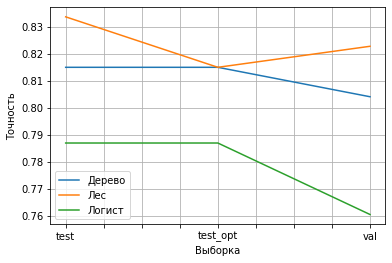

In [92]:
final = {'Выборка': ['val',
                     'test_opt',
                     'test'],
         'Дерево': [result_dt_c_val,
                    result_dt_c_test_opt,
                    result_dt_c_test], 
         'Лес': [result_rf_c_val,
                 result_dt_c_test_opt,
                 result_rf_c_test], 
         'Логист': [result_log_r_val,
                    result_log_r_test_opt,
                    result_log_r_test]
         }
final = pd.DataFrame(final) 
print()
display(final)
print()
display(pd.pivot_table(final, 
                       index=['Выборка'], 
                       values=['Дерево',
                               'Лес',
                               'Логист'])
                       .plot(kind='line', 
                             grid=True))
plt.xlabel("Выборка")
plt.ylabel("Точность")
plt.show() 

##### Вывод



*   Ранжировка точности моделей подтвердилась.
*   Точность прогноза по тестовой выборке будет несколько отличаться от валидационной.
*   Разлет точности прогноза получается в несколько процентов от расчетной величины. Например 78% плюс-минус 3%.